In [1]:
# Load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.linear_model import LogisticRegression
import project_env
from imp import reload

reload(project_env)

%matplotlib inline

**The `project_env` package**

I wrote this python package so loading and working with data is quicker and easier. There are several convenience methods:
* `load_split_bucket(station_id)` - Load data for a bike station that's already pre-split into train, dev and test. Includes doing data cleaning and thresholding. The output is a dictionary:
```
  {
    'train': (DataFrame, Series),
    'dev': (DataFrame, Series),
    'test': (DataFrame, Series),
    'train_times': Series,
    'dev_times': Series,
    'test_times': Series
  }
```
  Each `(DataFrame, Series)` tuple is the feature values and target variables, respectively.
  
  The `train_times` key contains the predicted time (i.e. 11 Nov, 18:30 PM)
* `merge_training(split, df)` - Given two outputs of `load()`, append the training set of the second argument to the training set of the first. This is useful when trying to load data from multiple stations, but testing on one station only.
* `binarize(data, target)` - Given output of `load()` and either 1 or -1, binarize the target variable to 0 or 1. Whatever class is in the second argument will become '1' in the new data.

In [2]:
data = project_env.load_split_bucket(519, target='y_60m', log=False)

In [3]:
training_X, training_y = data['train']

print(len(training_X.columns))
print(training_X.columns)
#training_X.describe().T

22
Index(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity',
       'nearestStormDistance', 'ozone', 'precipIntensity', 'precipProbability',
       'pressure', 'temperature', 'visibility', 'windBearing', 'windSpeed',
       'num_bikes_available_scaled', 'num_bikes_disabled_scaled',
       'num_docks_available_scaled', 'day_of_week', 'hour_of_day',
       'is_weekend', 'traffic_0_speed_scrub', 'traffic_1_speed_scrub',
       'traffic_2_speed_scrub'],
      dtype='object')


In [4]:
def do_logreg(split_data, squares=False, plot=True):
    train_X, train_y = split_data['train']
    dev_X, dev_y = split_data['dev']
    
    logreg = LogisticRegression(C=1e5)
    scaler = sklearn.preprocessing.StandardScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    
    if squares:
        train_X_scaled = np.concatenate([
                train_X_scaled,
                np.square(train_X_scaled)], axis=1)
    print('X shape:', train_X_scaled.shape)
    
    #print(pd.DataFrame(train_X_scaled).describe().T)
    logreg.fit(train_X_scaled, train_y)

    dev_X_scaled = scaler.transform(dev_X)
    if squares:
        dev_X_scaled = np.concatenate([
                dev_X_scaled,
                np.square(dev_X_scaled)], axis=1)
        
    dev_pred = logreg.predict(dev_X_scaled)
    dev_decision = logreg.predict_proba(dev_X_scaled)[:,1]
    acc = sklearn.metrics.accuracy_score(dev_y, dev_pred)
    print('Evaluating on dev set of {} examples'.format(len(dev_y)))
    print('Accuracy:', acc)
    
    print(sklearn.metrics.confusion_matrix(dev_y, dev_pred))

    if plot:
        plt.figure()
        plt.plot(dev_y.as_matrix()[100:500], 'b')
        plt.plot(dev_pred[100:500], 'g')
        plt.plot(0.5 * (dev_y.as_matrix() - dev_pred)[100:500], 'r')
        plt.ylim(-3, 3)
        plt.show()
    
    return logreg, scaler, dev_decision

X shape: (4236, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.810950413223
[[443 142]
 [ 41 342]]


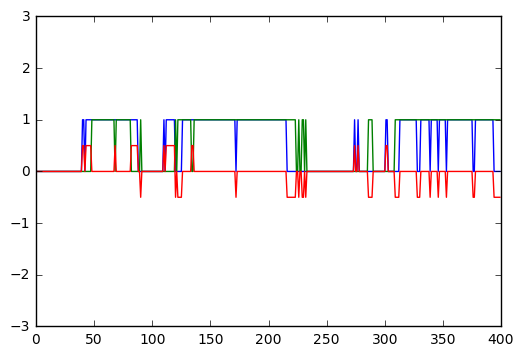

In [5]:
data_empty = project_env.binarize(data, -1)
logreg, scaler, dev_pred = do_logreg(data_empty)

# Evaluation

Model baseline
  Max precision: 0.528301886792 at recall 0.950391644909
  Threshold of max precision: 0.540983606557
Model basic
  Max precision: 0.581469648562 at recall 0.950391644909
  Threshold of max precision: 0.237080418438


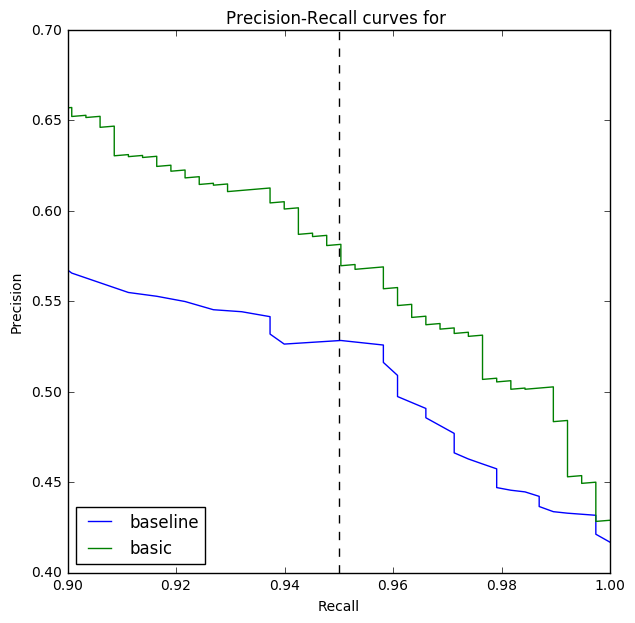

In [6]:
from sklearn.metrics import precision_recall_curve

gold_labels = data_empty['dev'][1]

def pr_curve(predictions, label, plot=True):
    curve = precision_recall_curve(gold_labels, predictions)
    precision, recall, thresholds = curve
    mp, mr, mt = project_env.max_precision_for_recall(curve)
    predicted_classes = predictions > mt
    print('Model', label)
    print('  Max precision:', mp, 'at recall', mr)
    print('  Threshold of max precision:', mt)
    plt.plot(recall, precision, label=label)
    return predicted_classes
   
plt.figure(figsize=(7, 7))
pr_curve(data_empty['dev'][0]['num_docks_available_scaled'], 'baseline')
predicted_basic = pr_curve(dev_pred, 'basic')

plt.xlim([0.9, 1.0])
plt.ylim([0.4, 0.7])
plt.axvline(x=0.95, color='k', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.title('Precision-Recall curves for ')
plt.show()

95% recall means that whenever the model tells a user to go to a station to pick up a bike at a designated time, 5% of the time, the station ends up empty (the bad case).

Given a model satisfies at least 95% recall, a higher precision means fewer occasions where a model turns the user away from the station even though it has bikes available (a more efficient model). So, we want to find a model that maximizes precision given a minimum recall.

In the plot above the `basic` model wins out at around 57% precision at 95% recall. So that means when the model says the station is empty, 57% of the time the station will actually be empty.

# Running on a date range

Run on the dev set range

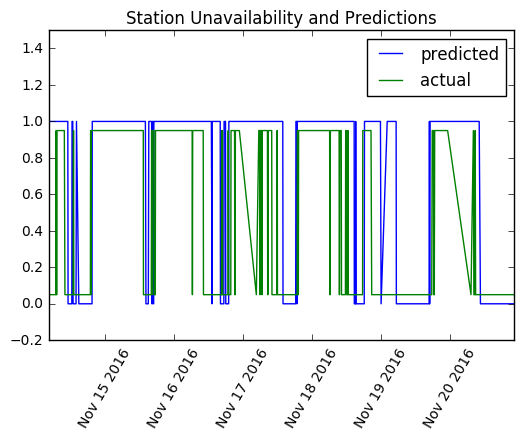

In [7]:
def plot_over_time(data, predictions):
    times = data['dev_times']
    gold_labels = data['dev'][1]
    
    curve = precision_recall_curve(gold_labels, predictions)
    mp, mr, mt = project_env.max_precision_for_recall(curve)
    predicted_classes = predictions > mt
    
    plt.figure()
    plt.plot(times.as_matrix(), predicted_classes, label='predicted')
    plt.plot(times.as_matrix(), gold_labels.as_matrix() * 0.9 + 0.05, label='actual')
    plt.title('Station Unavailability and Predictions')
    plt.legend()
    plt.xticks(rotation=60)
    plt.ylim(-0.2, 1.5)
    plt.show()

plot_over_time(data_empty, dev_pred)

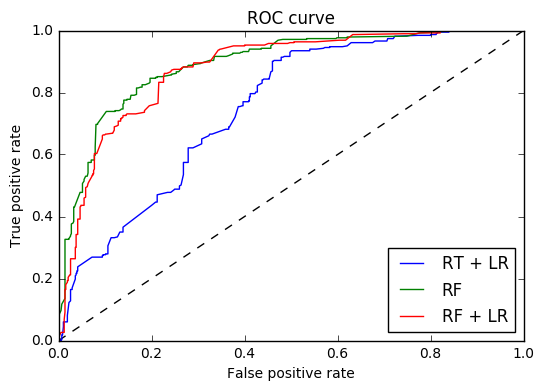

In [8]:
# example ensemble

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

train_X, train_y = data_empty['train']
dev_X, dev_y = data_empty['dev']

# It is important to train the ensemble of trees on a different subset
# of the training data than the linear regression model to avoid
# overfitting, in particular if the total number of leaves is
# similar to the number of training samples
train_X, train_X_lr, train_y, train_y_lr = train_test_split(train_X, train_y, test_size=0.5)
# train_X_lr, train_y_lr = data_empty['test']

# Unsupervised transformation based on totally random trees
rt = RandomTreesEmbedding(max_depth=3, random_state=0)
rt.fit(train_X, train_y)
# 'RandomTreesEmbedding' object has no attribute 'predict_proba'
# y_pred_rt = rt.predict_proba(dev_X)[:, 1]
# fpr_rt, tpr_rt, _ = roc_curve(dev_y, y_pred_rf)

rt_lm = LogisticRegression()
rt_lm_pipeline = make_pipeline(rt, rt_lm)
rt_lm_pipeline.fit(train_X, train_y)
y_pred_rt = rt_lm_pipeline.predict_proba(dev_X)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(dev_y, y_pred_rt)

# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3)
rf.fit(train_X, train_y)

# The random forest model by itself
y_pred_rf = rf.predict_proba(dev_X)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(dev_y, y_pred_rf)

rf_enc = OneHotEncoder()
rf_lm = LogisticRegression()
rf_enc.fit(rf.apply(train_X))
rf_lm.fit(rf_enc.transform(rf.apply(train_X_lr)), train_y_lr)
#rf_lm.fit(rf_enc.transform(rf.apply(train_X)), train_y)
y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(dev_X)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(dev_y, y_pred_rf_lm)

#rf_lm_pipeline = make_pipeline(rf, rf_lm)
#rf_lm_pipeline.fit(train_X, train_y)
#y_pred_rf_lm_pipeline = rf_lm_pipeline.predict_proba(dev_X)[:, 1]
#fpr_rf_lm_pipeline, tpr_rf_lm_pipeline, _ = roc_curve(dev_y, y_pred_rf_lm_pipeline)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_rt, tpr_rt, label='RT')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
#plt.plot(fpr_rf_lm_pipeline, tpr_rf_lm_pipeline, label='RF + LR p')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

/Users/id460/miniconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/id460/miniconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


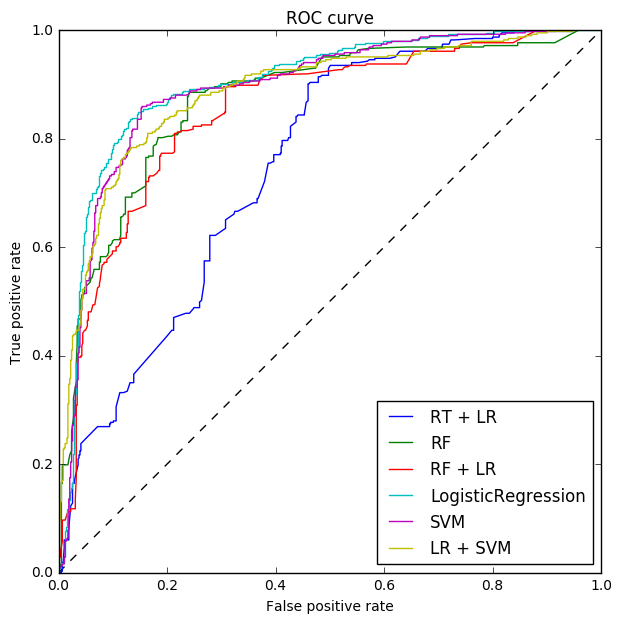

In [21]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

train_X, train_y = data_empty['train']
dev_X, dev_y = data_empty['dev']

# scale
scaler = sklearn.preprocessing.StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
dev_X_scaled = scaler.transform(dev_X)


# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3)
rf.fit(train_X, train_y)

# The random forest model by itself
y_pred_rf = rf.predict_proba(dev_X)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(dev_y, y_pred_rf)

rf_enc = OneHotEncoder()
rf_lm = LogisticRegression()
rf_enc.fit(rf.apply(train_X))
rf_lm.fit(rf_enc.transform(rf.apply(train_X_lr)), train_y_lr)
#rf_lm.fit(rf_enc.transform(rf.apply(train_X)), train_y)
y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(dev_X)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(dev_y, y_pred_rf_lm)

#y_pred_svm = svm_prob.predict_proba(dev_X_scaled)[:, 1]
#fpr_svm, tpr_svm, _ = roc_curve(dev_y, y_pred_svm)

# SVM
svm_prob = svm.SVC(kernel='linear', probability=True)
svm_prob.fit(train_X_scaled, train_y)
y_pred_svm = svm_prob.predict_proba(dev_X_scaled)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(dev_y, y_pred_svm)

# LogisticRegression
lr = LogisticRegression()
lr.fit(train_X_scaled, train_y)
y_pred_lr = lr.predict_proba(dev_X_scaled)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(dev_y, y_pred_lr)

# LR + SVM
lr_svm_pipeline = make_pipeline(lr, svm_prob)
lr_svm_pipeline.fit(train_X_scaled, train_y)
y_pred_lr_svm = lr_svm_pipeline.predict_proba(dev_X_scaled)[:, 1]
fpr_lr_svm, tpr_lr_svm, _ = roc_curve(dev_y, y_pred_lr_svm)


plt.figure(figsize=(7, 7))
plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_rt, tpr_rt, label='RT')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
#plt.plot(fpr_rf_lm_pipeline, tpr_rf_lm_pipeline, label='RF + LR p')
plt.plot(fpr_lr, tpr_lr, label='LogisticRegression')
plt.plot(fpr_svm, tpr_svm, label='SVM')
plt.plot(fpr_lr_svm, tpr_lr_svm, label='LR + SVM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Model baseline
  Max precision: 0.528301886792 at recall 0.950391644909
  Threshold of max precision: 0.540983606557
Model LR
  Max precision: 0.578696343402 at recall 0.950391644909
  Threshold of max precision: 0.270710207275
Model SVM
  Max precision: 0.561538461538 at recall 0.953002610966
  Threshold of max precision: 0.192288697585
Model LR + SVM
  Max precision: 0.540059347181 at recall 0.950391644909
  Threshold of max precision: 0.121039201572


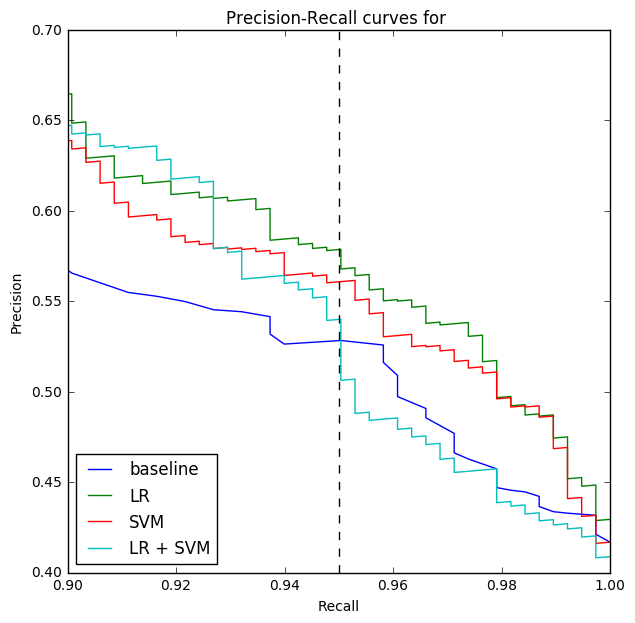

In [22]:
plt.figure(figsize=(7, 7))
pr_curve(data_empty['dev'][0]['num_docks_available_scaled'], 'baseline')
pr_curve(y_pred_lr, 'LR')
pr_curve(y_pred_svm, 'SVM')
pr_curve(y_pred_lr_svm, 'LR + SVM')

plt.xlim([0.9, 1.0])
plt.ylim([0.4, 0.7])
plt.axvline(x=0.95, color='k', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.title('Precision-Recall curves for ')
plt.show()
